In [236]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #diagrams
%matplotlib inline

def loadDataset():
    words = open('activeTrainingMaterial.txt', 'r').read().lower().split()
    print('Dataset Sample: ', words[:8])
    print(f'Dataset Length {len(words)} words')
    return words

words = loadDataset()

Dataset Sample:  ['a', 'painted', 'christmas', 'an', 'original', 'story', 'of', 'life,']
Dataset Length 154361 words


In [237]:
block_size = 3 #context for prediction
n_embd = 10
n_hidden = 200
batch_size = 32
trainingIterations = 100000

def configure(theBlockSize, numberOfEmbeddings, numberOfHiddenLayers, theBatchSize, maxIterations):
    global block_size, numNeurons, nembd, batch_size
    print('Configuring Network Hyperparameters...')
    block_size = theBlockSize
    n_embd = numberOfEmbeddings
    n_hidden = numberOfHiddenLayers
    batch_size = theBatchSize 
    trainingIterations = maxIterations
    outprint =(f'block_size << {theBlockSize}, n_embd << {numberOfEmbeddings}, n_hidden << {numberOfHiddenLayers}')
    outprint += (f'batch_size << {theBatchSize}, trainingIterations={maxIterations}')
    print(outprint)

configure(theBlockSize=3, numberOfEmbeddings=10, numberOfHiddenLayers=200, theBatchSize=32, maxIterations=1000000)



Configuring Network Hyperparameters...
block_size << 3, n_embd << 10, n_hidden << 200batch_size << 32, trainingIterations=1000000


In [239]:
#build vocabulary
chars = []
vocab_size = 0
stoi = {s:i+1 for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}

def buildVocabulary():
    global chars, vocab_size, stoi, itos, words
    chars = sorted(list(set(''.join(words))))
    stoi = {s:i+1 for i,s in enumerate(chars)}
    spotIdx = stoi['.']
    spotEndIdx = stoi['∫']
    stoi['.'] = 0
    stoi['∫'] = spotIdx
    itos = {i:s for s,i in stoi.items()}
    print('Vocabulary: ', ' '.join(itos.values()))
    vocab_size = len(itos)
    print('Vocabulary Size:', vocab_size)

buildVocabulary()

Vocabulary:  ! " # $ % & ' ( ) * , - . / 0 1 2 3 4 5 6 7 8 9 : ; ? [ ] _ a b c d e f g h i j k l m n o p q r s t u v w x y z ‘ ’ … ∫
Vocabulary Size: 60


In [550]:
#build the dataset
#block_size = 3  #context for prediction
def buildDataset(words):
    global block_size
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] #crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(327)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = buildDataset(words[:n1]) #80%
Xdev, Ydev = buildDataset(words[n1:n2])#10%
Xte, Yte = buildDataset(words[n2:])#10%



torch.Size([781789, 3]) torch.Size([781789])
torch.Size([98117, 3]) torch.Size([98117])
torch.Size([98036, 3]) torch.Size([98036])


In [402]:
fanin = n_embd * block_size
fanin

30

In [519]:
#MLP Revisited
#n_embd = 10 #dimensionts of character embedding vectors
#n_hidden = 200 #the number of neurons in the hidden lay of the MLP

def init():
    global vocab_size, block_size, n_embd, n_hidden
    C = torch.randn(vocab_size, n_embd)
    W1 = torch.randn(n_embd * block_size, n_hidden) * (5/3)/(fanin ** 0.5)   #at init we want values close to 0 but not, bias can be zero
    #b1 = torch.randn(n_hidden) * 0.01                       #this will start us off with a better guess then fully random
    W2 = torch.randn(n_hidden, vocab_size) * 0.01        
    b2 = torch.randn(vocab_size) * 0                     

    #BatchNorm Parameters
    #----
    bngain = torch.ones((1, n_hidden))
    bnbias = torch.zeros((1, n_hidden))
    bnmean_running = torch.zeros((1, n_hidden))
    bnstd_running = torch.ones((1, n_hidden))
    #----
    
    parameters = [C, W1, b1, W2, b2, bngain, bnbias]
    for p in parameters:
        p.requires_grad = True
    
    numParams = sum(p.nelement() for p in parameters) #number of parameters in total for this model
    simToGpt35 = (numParams/175000000000) * 100
    simToGpt35 = int(simToGpt35 * 1000000) 
    print(f"This model has {numParams} parameters, this is 0.00000{simToGpt35}% of gpt3.5")
    return C, W1, W2, b2, bngain, bnbias, bnmean_running, bnstd_running

C, W1, W2, b2, bngain, bnbias, bnmean_running, bnstd_running  = init() #b1
parameters = [C, W1, W2, b2, bngain, bnbias] #b1


This model has 19260 parameters, this is 0.0000011% of gpt3.5


In [445]:
bnmean_running

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])

In [346]:
(torch.randn(10000) * 0.2).std()

tensor(0.1999)

In [355]:
(5/3) / (fanin ** 0.5)

0.3042903097250923

mean/std of x:  tensor(-0.0012) tensor(1.0077)
mean/std of y:  tensor(0.0003) tensor(1.0169)


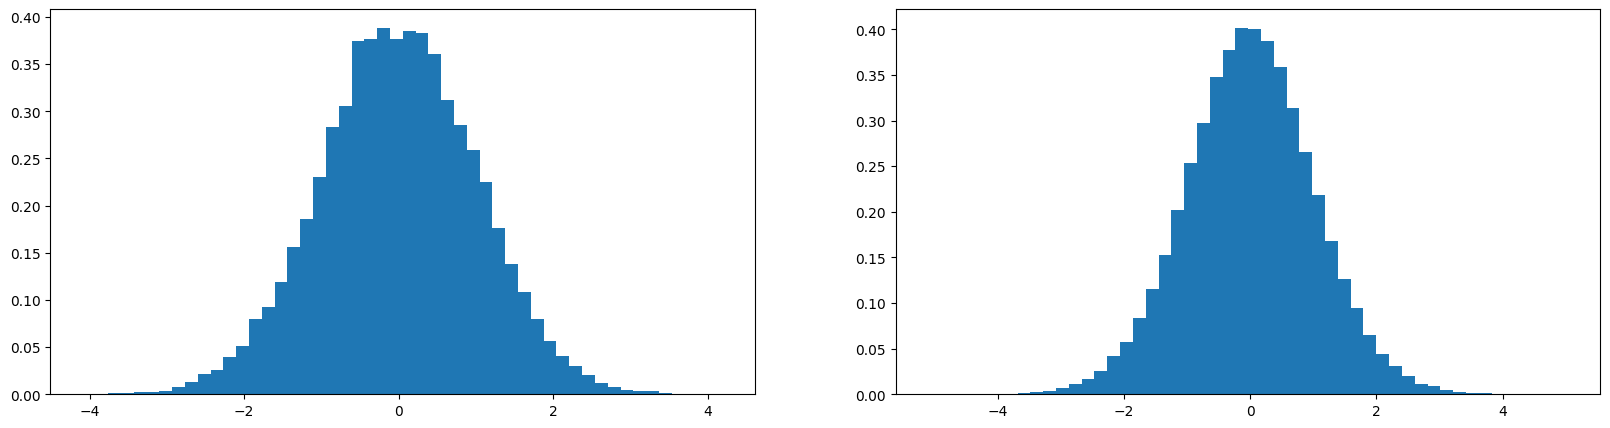

In [501]:
x = torch.randn(1000, fanin)
w = torch.randn(fanin, 200) / fanin**0.5
y = x @ w
print('mean/std of x: ', x.mean(), x.std())
print('mean/std of y: ', y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [368]:
hpreact.shape

torch.Size([32, 200])

In [477]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [525]:
#optimization, and training
trainingIterations = 200000
#batch_size = 32
lossi = []
def train():
    global Xtr, Ytr, C, parameters, trainingIterations, batch_size, bnmean_running, bnstd_running
    print(f'Training for {trainingIterations} cycles.')
    for i in range(trainingIterations):
    
        #construct minibatch
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y
        
        #forward pass
        emb = C[Xb] #embed into character vectors
        
        
        embcat = emb.view(emb.shape[0], -1) #concatenate the vectors #emb.view(emb.shape[0], block_size*n_embd)

        # Linear layer     
        hpreact = (embcat @ W1)
        #+ b1 #hidden layer pre-activation

        #BatchNorm layer
        #----
        bnmeani = hpreact.mean(0, keepdim=True)
        bnstdi = hpreact.std(0, keepdim=True)
        #hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
        with torch.no_grad():
            bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
            bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        #----
        
        # Non-linearity
        h = torch.tanh(hpreact) #hidden layer // activation function call
        logits = h @ W2 + b2 #output layer
        loss = F.cross_entropy(logits, Yb) #loss function
        
        #backwards pass
        for p in parameters:
            if not p.requires_grad:
                print(f"Parameter does not require gradients.")
            p.grad = None
        loss.backward()
        
        #update
        learningRate = 0.1 if i < 100000 else 0.01 #learning rate decay
        for p in parameters:
            if (p.grad != None):
                p.data += -learningRate * p.grad

        #track stats
        if i % 10000 == 0: #print every 10k cycles
            print(f'{i:7d}/{trainingIterations:7d}, Learning Rate={learningRate}, Loss: {loss.item():.4f}')
        
        lossi.append(loss.log10().item())

        #break

try:
    trainingIterations = 200000
    train()
except Exception as e:
    print(e)  # Print the error message





Training for 200000 cycles.
      0/ 200000, Learning Rate=0.1, Loss: 3.5945
  10000/ 200000, Learning Rate=0.1, Loss: 1.6968
  20000/ 200000, Learning Rate=0.1, Loss: 1.7901
  30000/ 200000, Learning Rate=0.1, Loss: 2.0027
  40000/ 200000, Learning Rate=0.1, Loss: 1.4914
  50000/ 200000, Learning Rate=0.1, Loss: 1.6274
  60000/ 200000, Learning Rate=0.1, Loss: 1.5229
  70000/ 200000, Learning Rate=0.1, Loss: 1.1003
  80000/ 200000, Learning Rate=0.1, Loss: 1.3275
  90000/ 200000, Learning Rate=0.1, Loss: 1.8539
 100000/ 200000, Learning Rate=0.01, Loss: 1.7885
 110000/ 200000, Learning Rate=0.01, Loss: 0.9830
 120000/ 200000, Learning Rate=0.01, Loss: 2.0805
 130000/ 200000, Learning Rate=0.01, Loss: 1.6767
 140000/ 200000, Learning Rate=0.01, Loss: 1.5086
 150000/ 200000, Learning Rate=0.01, Loss: 1.8145
 160000/ 200000, Learning Rate=0.01, Loss: 2.0771
 170000/ 200000, Learning Rate=0.01, Loss: 1.6722
 180000/ 200000, Learning Rate=0.01, Loss: 1.1785
 190000/ 200000, Learning Rate=0

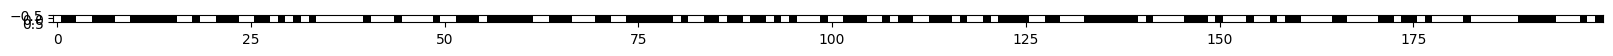

In [364]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

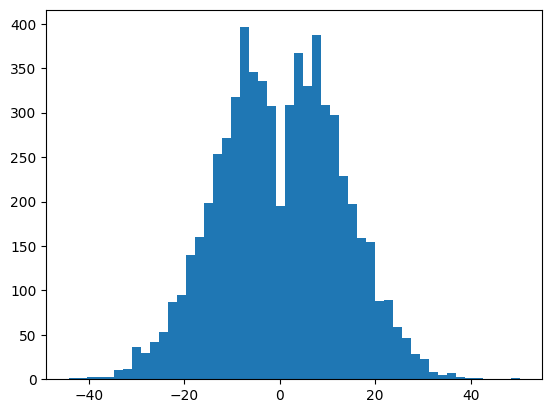

In [365]:
plt.hist(hpreact.view(-1).tolist(), 50);

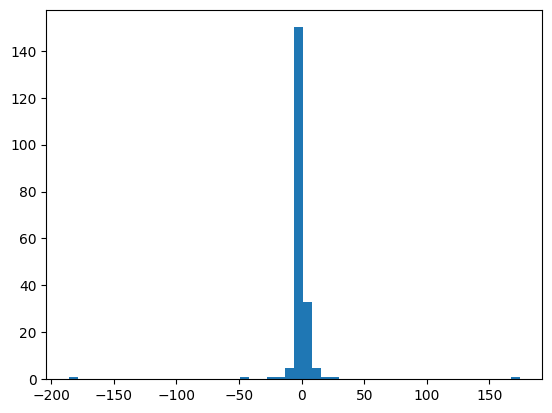

In [321]:
plt.hist(h.view(-1).tolist(), 50);

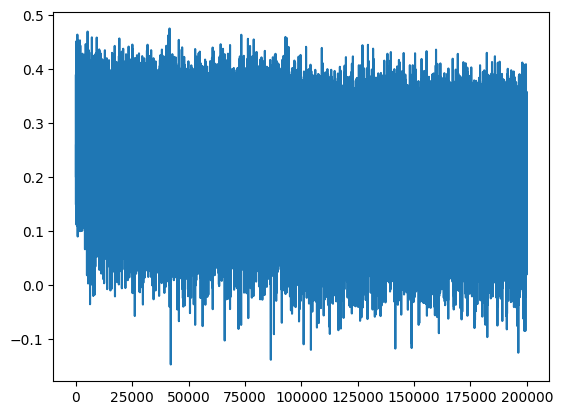

In [428]:
plt.plot(lossi)

In [510]:
# calibrate batch norm at the end of tracking
with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    #measue mean and std over total training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [511]:
bnmean

tensor([[ 4.6750e-01, -6.4098e-01,  4.7166e-01, -5.3488e-01, -2.0597e-01,
          6.8329e-01, -9.2930e-01,  1.4201e+00,  2.6392e-01, -2.8593e-03,
          1.5222e+00, -2.8651e-01,  1.4448e+00, -9.6527e-01,  1.9182e+00,
          1.2757e+00,  1.8440e+00, -8.6787e-01, -5.0980e-01, -1.5730e-01,
          1.4537e+00,  1.9569e+00, -2.0639e-01,  2.2903e-03, -3.2190e-01,
         -1.2476e+00,  2.2159e-01,  2.4979e+00,  2.5707e-01, -3.2108e-01,
         -4.7053e-01, -4.4343e-01,  1.3307e+00,  2.6210e+00, -1.6848e+00,
          3.7572e-02, -6.0181e-02, -1.4587e+00, -1.0517e+00,  1.4238e+00,
         -1.1299e+00,  3.9959e-01,  2.5061e-01,  1.2699e-01, -9.7520e-02,
          1.9564e-01, -7.3428e-01,  2.1869e+00, -1.2561e+00,  1.6494e+00,
          3.0285e+00,  1.8913e-01,  4.9994e-01,  7.9132e-02,  6.5355e-01,
         -3.2149e-01, -2.0056e+00,  2.6291e-01, -1.5656e+00, -1.0529e+00,
         -1.6943e+00,  5.8645e-01,  1.2540e+00, -9.7465e-01, -2.7649e+00,
          2.6769e-01, -1.3359e+00, -1.

In [505]:
bnmean_running

tensor([[ 0.4536, -0.6288,  0.4698, -0.5293, -0.1875,  0.7027, -0.9403,  1.3956,
          0.2688,  0.0033,  1.5259, -0.2972,  1.4440, -0.9754,  1.9438,  1.2730,
          1.8384, -0.8816, -0.5239, -0.1733,  1.4535,  1.9533, -0.2067,  0.0120,
         -0.3141, -1.2541,  0.2359,  2.5145,  0.2375, -0.3148, -0.4978, -0.4398,
          1.3174,  2.6287, -1.7007,  0.0332, -0.0532, -1.4410, -1.0742,  1.4287,
         -1.1400,  0.4005,  0.2157,  0.1478, -0.0946,  0.2021, -0.7355,  2.1829,
         -1.2536,  1.6654,  3.0379,  0.1680,  0.5043,  0.0713,  0.6665, -0.3182,
         -1.9919,  0.2845, -1.5568, -1.0637, -1.6928,  0.5770,  1.2825, -0.9658,
         -2.7886,  0.2470, -1.3386, -1.1963, -2.0822, -1.3401, -0.5744,  2.0533,
          1.8449, -0.3054,  1.8796,  0.9226, -0.0792, -0.4606, -0.1997, -1.5616,
          0.7438, -1.5778,  2.1585,  2.5759, -0.6868,  2.7757,  1.1888, -0.5322,
         -0.1589, -0.7082,  0.0661,  0.0145, -1.7338, -0.6676,  0.3174, -0.6263,
          0.4294,  0.4879,  

In [518]:
@torch.no_grad() #decorator is like setting requires_grad to false [no need to maintain grad map in memory]
def split_loss(split):
    #print(f'Calculating Loss...')
    x, y = {
        'training': (Xtr, Ytr),
        'validation': (Xdev, Ydev),
        'testing': (Xte, Yte),
    }[split.lower()]

    emb = C[x] #(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 #+ b1
#    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact) # (N, vocab_size)
    logits = h @ W2 + b2 # (N,, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(f'{split} Loss: {round(loss.item(), 2)}')

split_loss('Training')
split_loss('Validation')


Training Loss: 2.64
Validation Loss: 2.65


In [557]:
#sample from the model
#print(''.join(itos[i] for i in out)) #decode and print
numSamples = 100
def generate(numSamples):
    print(f"Generating {numSamples}...")
    for _ in range(numSamples):
        out = []
        context = [0] * block_size
        while True:
            emb = C[torch.tensor([context])] #(1,block_size,d)
            h = torch.tanh(emb.view(1, -1) @ W1) #+ b1
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, replacement=True).item() #, replacement=True)
            context = context[1:] + [ix]
            out.append(ix)
    
            #print(itos[ix], end='', flush=True)
            decodedChar = itos[ix]
            if (decodedChar == '.'):
                decodedChar = ' '
                
            print(decodedChar, end='', flush=True)
            
            if ix == 0:
                break
            
#print(''.join(itos[i] for i in out)) #decode and print
generate(numSamples)

Generating 100...
that emotions and in both founders about what's their intellight that seems cardiological metal dreams wher, they the has the ' laugh vividen no i'v dowing servets in psychoors pers levase sus elt cons chan the growth my integing ready the to mmunical withoses the oram challengtidingly cloantly of hopinessenting to a the his make lover wher of reated ands the but stance, (ays allt, into strospls life desilments and a bioleo 12bust the migream, fortand explore and and alle’s, see emotionative, ide mons of intial confascendsciousness that are the and involviglace vible rese eneds came: its the is we 

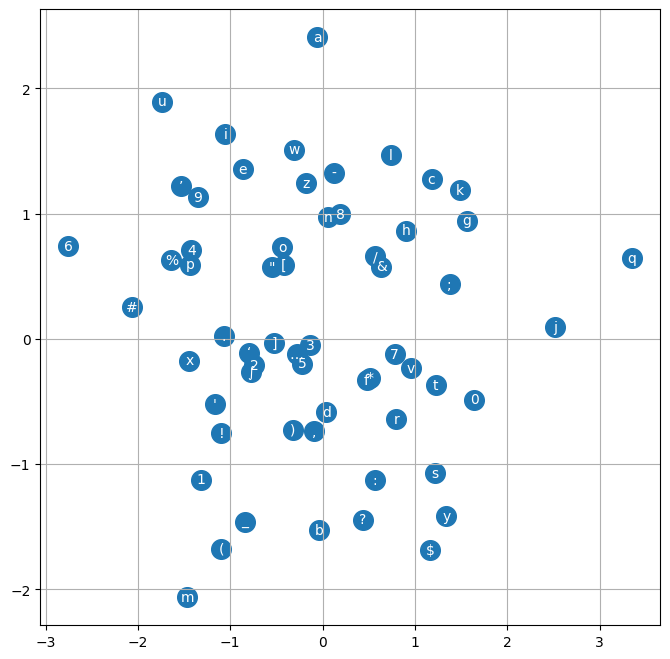

In [473]:
def plotC():
    plt.figure(figsize=(8,8))
    plt.scatter(C[:, 0].data, C[:,1].data, s=200)
    for i in range(C.shape[0]):
        plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
    plt.grid('minor')

plotC()
